In [1]:
from __future__ import annotations
%pylab inline
import cv2
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


Load image and convert to grayscale. Use matplotlib imread function to display properly.

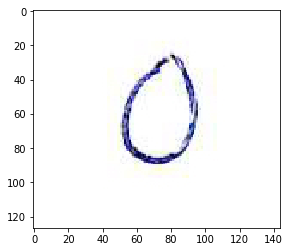

In [2]:
im_org = mpimg.imread("img/0.jpg")
im_gray = cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY)
imshow(im_org);

Blur the image to smoothen it.

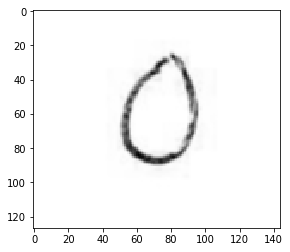

In [3]:
blur = cv2.GaussianBlur(im_gray, (3, 3), 0)
imshow(blur, cmap="gray");

Convert to binary image.

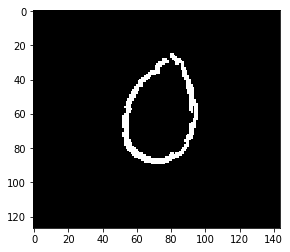

In [4]:
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7,10)
imshow(thresh, cmap="gray");

Find contours and display them.

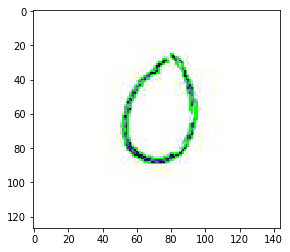

In [5]:
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im_contours = cv2.drawContours(im_org.copy(), contours, -1, (0, 255, 0), 1)
imshow(im_contours, cmap="gray");

Find the enclosing rectangle.

Found number width: 44, height: 65


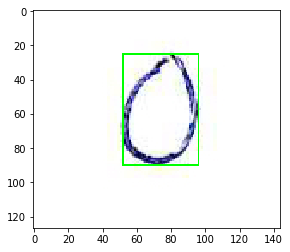

In [6]:
x,y,w,h = cv2.boundingRect(contours[0])
im_rect = cv2.rectangle(im_org.copy(), (x,y),(x+w,y+h),(0, 255, 0), 1)
print(f"Found number width: {w}, height: {h}")
imshow(im_rect);

Crop the number.

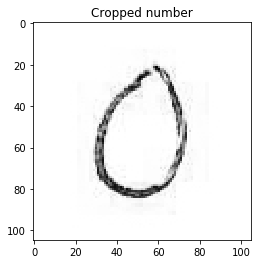

In [7]:
b = 20

d = int(abs((w - h) / 2))
if w > h:
    im_cropped = im_gray.copy()[y-b-d:y+b+w, x+b:x+b+w]
else:
    im_cropped = im_gray.copy()[y-b:y+b+h, x-b-d:x+b+h-d]
    
title("Cropped number")
imshow(im_cropped, cmap="gray");

Scale to 28x28 like in MNIST.

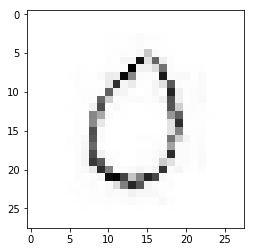

In [8]:
im_resized = cv2.resize(im_cropped.copy(), (28, 28))
imshow(im_resized, cmap="gray")

Put that all in a function.

In [9]:
def find_number(fn: str):
    min_width = 2
    min_height = 6
    
    # read original image
    im_org = mpimg.imread(fn)
    
    # convert to grayscale
    im_gray = cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY)
    
    # blur
    blur = cv2.GaussianBlur(im_gray, (3, 3), cv2.BORDER_DEFAULT)
    
    # convert to binary
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 10)
    
    # find contours and rectangles around them
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(cont) for cont in contours]
    
    # filter rectangles by size
    filtered_rects = [(x, y, w, h) for (x, y, w, h) in rects if (w >= min_width and h >= min_height)]
    
    # draw all rectangles with the right size in the image
    im_with_rects = im_org.copy()
    for rect in filtered_rects:
        x, y, w, h = rect
        cv2.rectangle(im_with_rects, (x,y),(x+w,y+h),(0, 255, 0), 3)
        
    return (im_with_rects, filtered_rects)

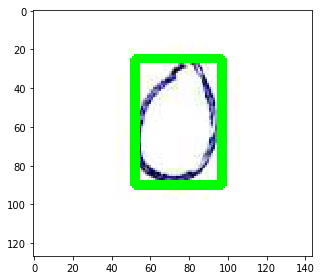

In [10]:
figsize(5, 10)
im, _ = find_number("img/0.jpg")
imshow(im)

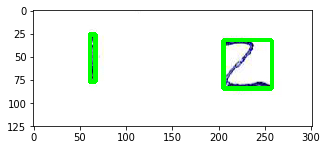

In [11]:
im, _ = find_number("img/1_2.jpg")
imshow(im)

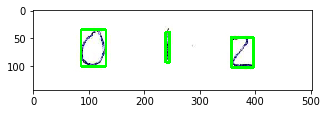

In [12]:
im, _ = find_number("img/0_1_2.jpg")
imshow(im)

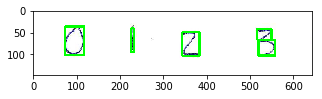

In [13]:
im, _ = find_number("img/0_1_2_3.jpg")
imshow(im)

# Rectangles that touch each other should result in a bigger rectangle

In [14]:
from collections import namedtuple

Rect = namedtuple("Rect", "x y w h")

def rects_overlap(r1: Rect, r2: Rect, g: int = 0) -> bool:
    """Checks if two rectangles overlap / touch each other."""
    x00, y00, x01, y01 = r1.x, r1.y, r1.x + r1.w, r1.y + r1.h
    x10, y10, x11, y11 = r2.x, r2.y, r2.x + r2.w, r2.y + r2.h
    
    return (
        x10 - x01 <= g and x00 - x11 <= g and y10 - y01 <= g and y00 - y11 <= g
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False

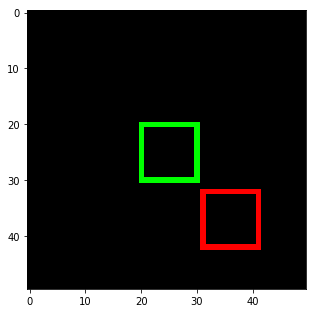

In [15]:
r1 = Rect(31, 32, 10, 10)
r2 = Rect(20, 20, 10, 10)

im = np.zeros((50, 50, 3))
cv2.rectangle(im, (r1.x, r1.y), (r1.x + r1.w, r1.y + r1.h), (255, 0, 0), 1)
cv2.rectangle(im, (r2.x, r2.y), (r2.x + r2.w, r2.y + r2.h), (0, 255, 0), 1)

imshow(im)
rects_overlap(r1, r2, 1)

Let' s check if this works with some numbers.

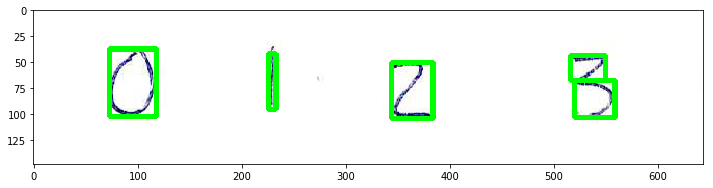

In [16]:
figsize(12, 20)
im, rects = find_number("img/0_1_2_3.jpg")
imshow(im);

Rect 0 overlaps rect 2.


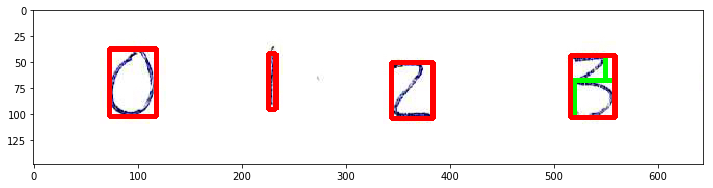

In [17]:
def combine_rects(rects):
    # possible gap between rectangles
    gap = 5
    overlapping_rects = set()
    res = []
    
    # find overlapping rects
    for i0, (x0, y0, w0, h0) in enumerate(rects):
        overlaps = False
        for i1, (x1, y1, w1, h1) in enumerate(rects):
            if i0 == i1: 
                continue
            r0 = Rect(x0, y0, w0, h0)
            r1 = Rect(x1, y1, w1, h1)

            if rects_overlap(r0, r1, g=gap):
                overlaps = True
                overlapping_rects.add((min(i0, i1), max(i0, i1)))

        if not overlaps:
            res.append((x0, y0, w0, h0))
        
    for i0, i1 in overlapping_rects:
        x0, y0, w0, h0 = rects[i0]
        x1, y1, w1, h1 = rects[i1]
        print(f"Rect {i0} overlaps rect {i1}.")
        new_x0, new_y0 = min(x0, x1), min(y0, y1)
        new_x1, new_y1 = max(x0 + w0, x1 + w1), max(y0 + h0, y1 + h1)
        res.append((new_x0, new_y0, new_x1 - new_x0, new_y1 - new_y0))
        # cv2.rectangle(im, (new_x0, new_y0), (new_x1, new_y1),(255, 0, 0), 3)
        return res

combined_rects = combine_rects(rects)
for x, y, w, h in combined_rects:
    cv2.rectangle(im, (x, y), (x + w, y + h),(255, 0, 0), 3)

imshow(im);

This looks good. The 3 consisted of 2 rectangles that touched each other. The algorithm made one rectangle of them. Now we check this out for a whole line.

Rect 6 overlaps rect 18.


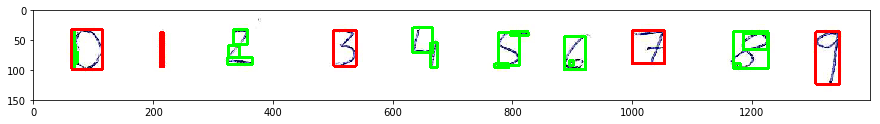

In [18]:
figsize(15, 30)
im, rects = find_number("img/row.jpg")
combined_rects = combine_rects(rects)
for x, y, w, h in combined_rects:
    cv2.rectangle(im, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im);

This doesn' t look so good anymore. The algorithm seems to have problems if it needs to combine more then two rectangles. This clearly needs improvement.

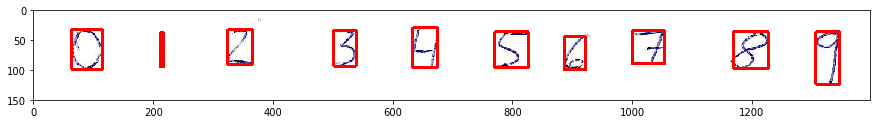

In [19]:
def combine_rects(rects):
    # possible gap between rectangles
    gap = 5
    overlapping_rects = set()
    res = []
    
    while True:
        # find overlapping rects
        for i0, (x0, y0, w0, h0) in enumerate(rects):
            overlaps = False
            for i1, (x1, y1, w1, h1) in enumerate(rects):

                if i0 == i1: 
                    continue
                r0 = Rect(x0, y0, w0, h0)
                r1 = Rect(x1, y1, w1, h1)

                if rects_overlap(r0, r1, g=gap):
                    # print(f"Rects {i0} and {i1} overlap")
                    new_x = min(x0, x1)
                    new_y = min(y0, y1)
                    new_w = max(x0 + w0, x1 + w1) - new_x
                    new_h = max(y0 + h0, y1 + h1) - new_y
                    
                    new_rect = (new_x, new_y, new_w, new_h)
                    
                    new_rects = [x for i, x in enumerate(rects) if i not in (i0, i1)]
                    new_rects.append(new_rect)
                    rects = new_rects
                    overlaps = True
                    break
            if overlaps:
                break
        else:
            break
    return rects
        
_, rects = find_number("img/row.jpg")
im = mpimg.imread("img/row.jpg")
combined_rects = combine_rects(rects)
for x, y, w, h in combined_rects:
    cv2.rectangle(im, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im);

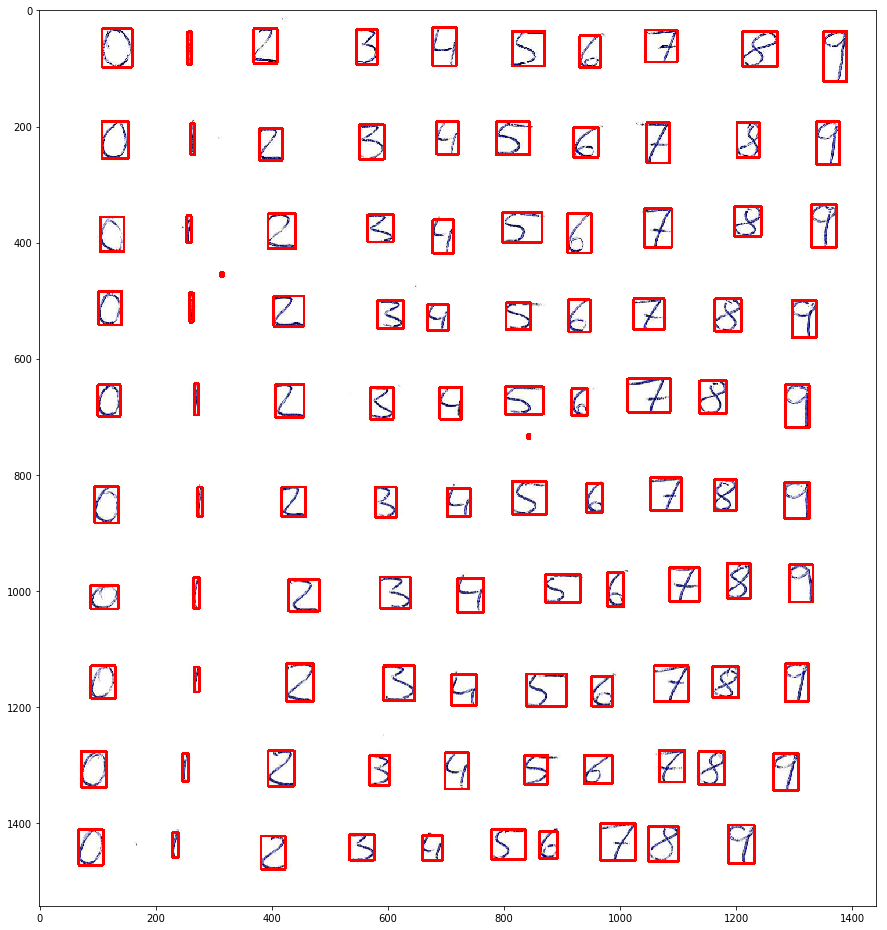

In [20]:
_, rects = find_number("img/input.bmp")
im = mpimg.imread("img/input.bmp")
combined_rects = combine_rects(rects)
for x, y, w, h in combined_rects:
    cv2.rectangle(im, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im);

This looks already really good. Now we remove some of the rectangles that are too small.

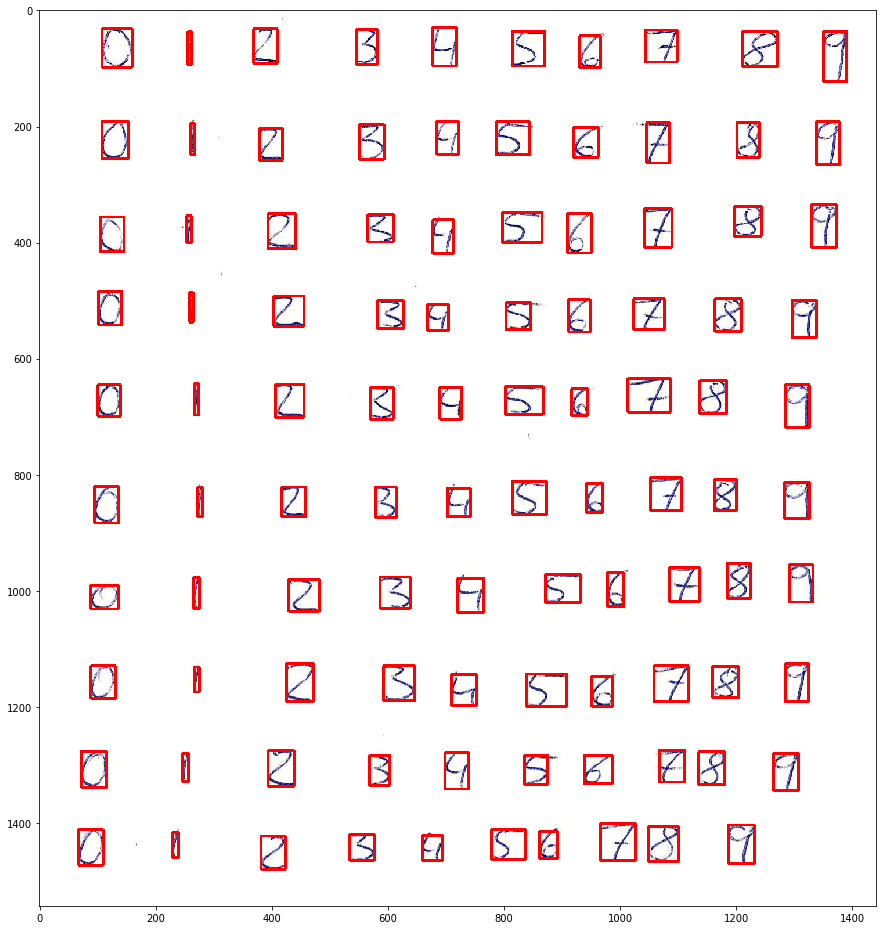

In [21]:
min_width_height = 5

_, rects = find_number("img/input.bmp")
im = mpimg.imread("img/input.bmp")
combined_rects = combine_rects(rects)
filtered_rects = [x for x in combined_rects if x[2] > min_width_height and x[3] > min_width_height]
for x, y, w, h in filtered_rects:
    cv2.rectangle(im, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im);

There are still some bits missing from some numbers but it should be ok for now. Now we want to crop each image.

In [22]:
def crop_rect(im, rect, border: int = 20):
    x, y, w, h = rect
    b = border
    d = int(abs((w - h) / 2))
    if w > h:
        im_cropped = im.copy()[y-b-d:y+b+w, x-b:x+b+w]
    else:
        im_cropped = im.copy()[y-b:y+b+h, x-b-d:x+b+h-d]
    return im_cropped

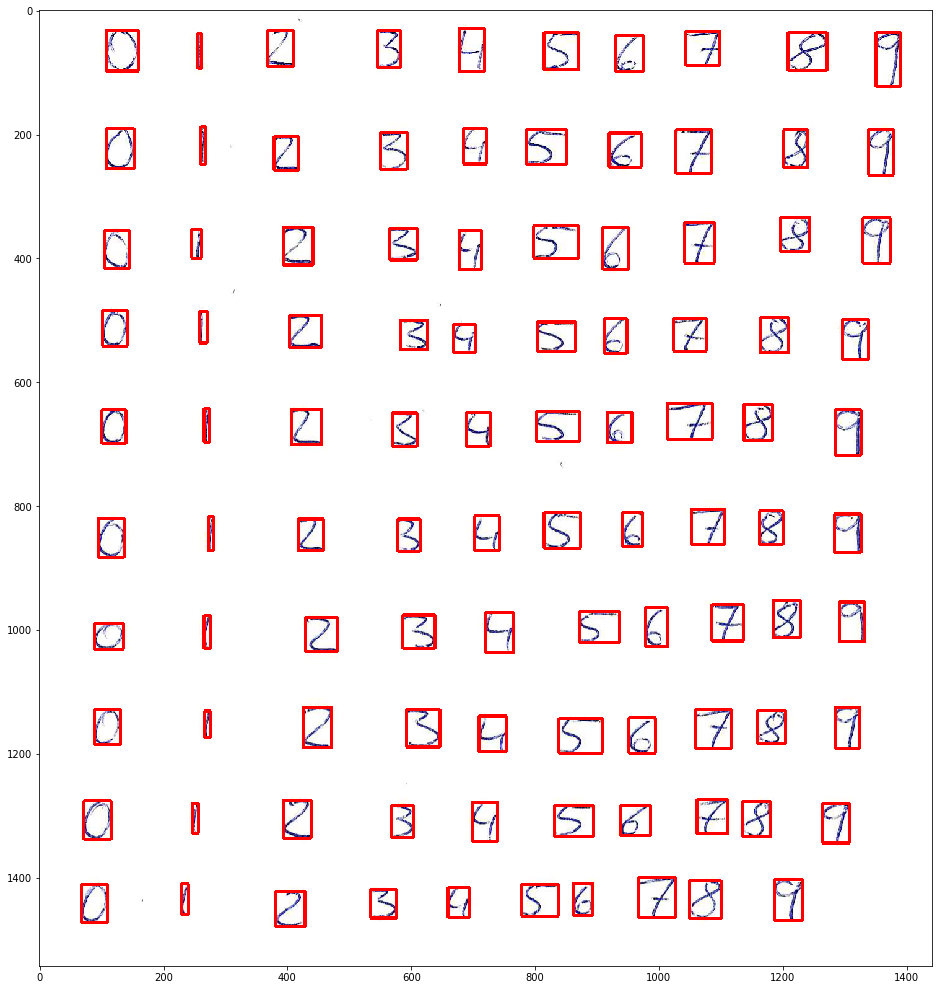

In [23]:
figsize(16, 20)
min_width_height = 5

# read original image
im_org = mpimg.imread("img/input.bmp")

# convert to grayscale
im_gray = cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY)

# blur
blur = cv2.GaussianBlur(im_gray, (3, 3), cv2.BORDER_DEFAULT)

# convert to binary
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 10)

# find contours and rectangles around them
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rects = combine_rects([cv2.boundingRect(cont) for cont in contours])
rects = [x for x in rects if x[2] > min_width_height and x[3] > min_width_height]

for x, y, w, h in rects:
    cv2.rectangle(im_org, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im_org);

cropped_numbers = [crop_rect(im_gray, rect) for rect in rects]
resized_numbers = [cv2.resize(im.copy(), (28, 28)) for im in cropped_numbers]

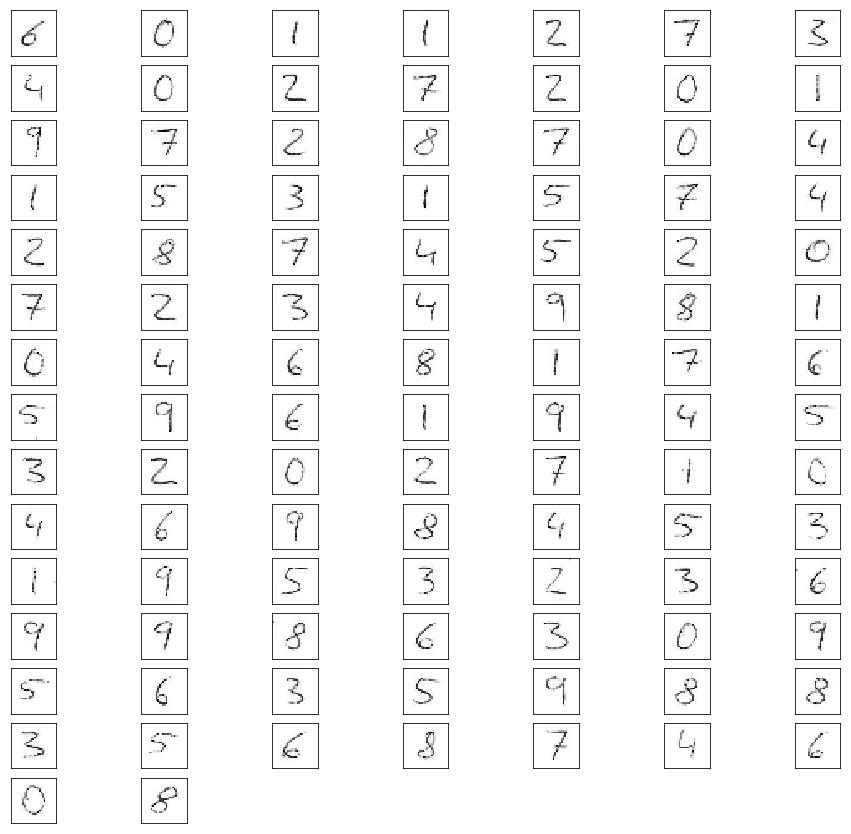

In [24]:
figure(781, figsize=(16, 20))
ROWS = 20
COLS = 7


for i, im in enumerate(resized_numbers, 1):
    subplot(ROWS, COLS, i)
    xticks([], [])  # remove xticks
    yticks([], [])  # remove yticks
    imshow(im, cmap="gray")

    if i == ROWS * COLS:
        break
        


Looks great. The only thing that got missing during the procedure is the labels of the numbers. We could add them manually but actually the numbers were written in a row from 0 to 9. So we should be able to get the label from the position in a row.

In [25]:
def rect_in_row(rect, row):
    if len(row):
        mid = np.mean([y + h / 2 for (x, y, w, h) in row])
        tol = np.mean([h / 2 for (_, _, _, h) in row])
        x, y, w, h = rect
        if (y + h / 2) <= mid + tol and (y + h / 2) >= mid - tol:
            return True
        else:
            return False
    return True
 
rows = []
for rect in rects:
    for row in rows:
        if rect_in_row(rect, row):
            row.append(rect)
            break
    else:
        rows.append([rect])
        
# sort images in row by x coordinate
for i in range(len(rows)):
    rows[i] = sorted(rows[i])

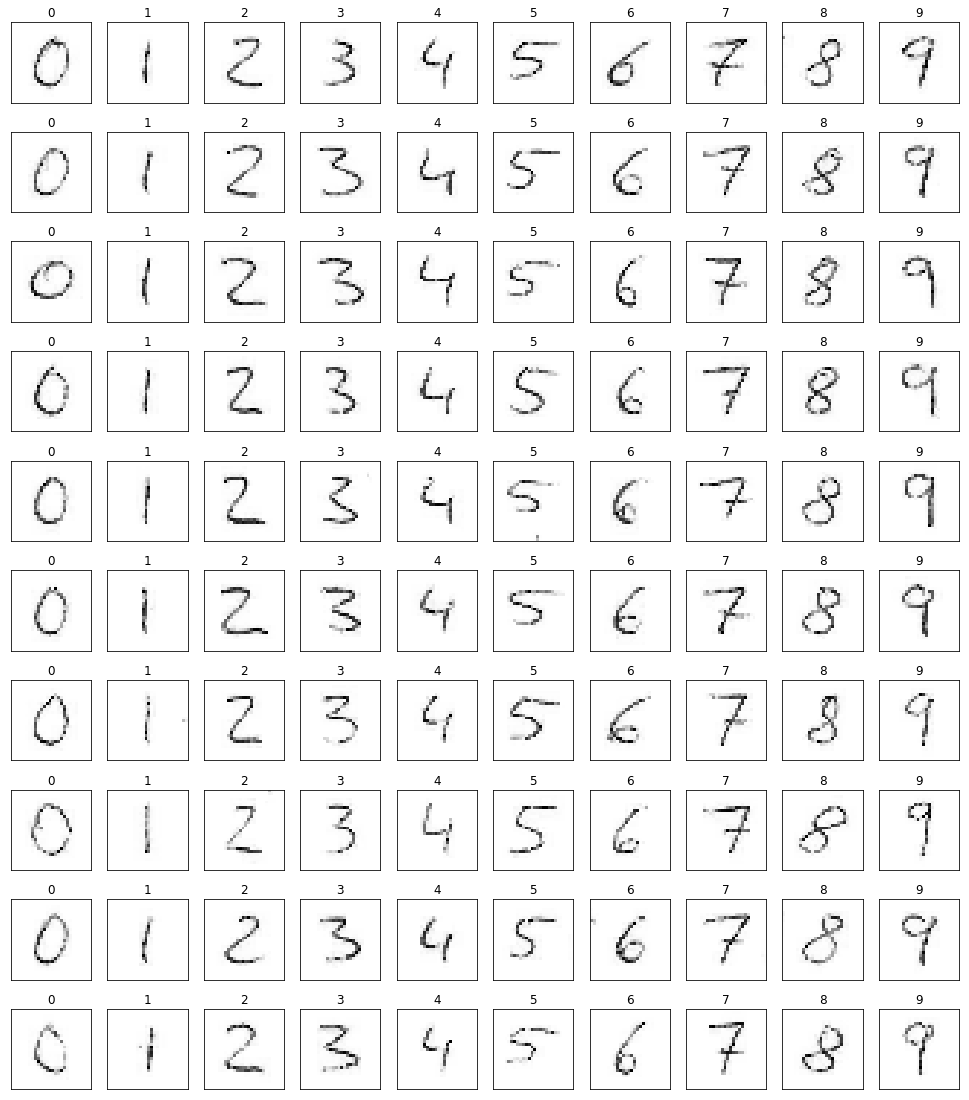

In [26]:
figure(781, figsize=(17, 40))
ROWS = 20
COLS = 10

i = 0
for i_row, row in enumerate(rows, 1):
    cropped = [crop_rect(im_gray, rect) for rect in row]
    resized = [cv2.resize(im.copy(), (28, 28)) for im in cropped]
    for i, im in enumerate(resized):
        subplot(ROWS, COLS, 10 * (i_row - 1) + i + 1)
        title(f"{i}")
        xticks([], [])  # remove xticks
        yticks([], [])  # remove yticks
        imshow(im, cmap="gray")      


Now we need to put the data in the right shape. The MNIST data is organized as numpy array of shape (count, 28, 28).

In [27]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [28]:
X = []
y = []
for row in rows:
    cropped = [crop_rect(im_gray, rect) for rect in row]
    resized = [cv2.resize(im.copy(), (28, 28)) for im in cropped]            
    for label, im in enumerate(resized):
        X.append(im)
        y.append(label)

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

In [29]:
X.shape, y.shape

((100, 28, 28), (100,))

Looks great. Now we save this to file.

In [33]:
import pickle
with open("handwritten.pkl", "wb") as f:
    pickle.dump((X, y), f)